# Covid-19 Vaccines in California and their Impacts

### Hypothesis:
#### 1.	College towns had an impact on Covid-19 surges in 2020.
#### 2.	Vaccines have directly impacted California’s case and death rates.

In [25]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import requests
from census import Census
from us import states
import gmaps

#import API key for US Census API
from config import api_key,gkey
gmaps.configure(api_key=gkey)
c = Census(api_key)

### Cleaning Data

In [2]:
# Cleaning Cases Data
case_df = pd.read_csv("Data/covid19cases_test.csv")
case_df.head()

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,4/23/2021,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,106.0,3.0,11251.0
1,4/23/2021,Alpine,County,1117.0,0.0,0.0,NaN,NaN,0.0,0.0,2.0
2,4/23/2021,Amador,County,38531.0,0.0,0.0,NaN,NaN,4.0,0.0,487.0
3,4/23/2021,Butte,County,217769.0,0.0,0.0,NaN,NaN,16.0,0.0,454.0
4,4/23/2021,Calaveras,County,44289.0,0.0,0.0,NaN,NaN,5.0,0.0,135.0


In [3]:
# change date column to easier to compare format
case_df.date = pd.to_datetime(case_df['date'],format='%m/%d/%Y')

# filter out dates past 3-31-21, as well as rows with useless data
clean_case = case_df.loc[(case_df.date<dt.datetime(2021,4,1)) & \
                         (case_df.area != 'Out of state') & \
                         (case_df.area != 'California')& \
                         (case_df.area != 'Unknown')]

# filter out columns we dont need
clean_case = clean_case[['date','area','population','cases','deaths','total_tests','positive_tests']]

# replace missing data with 0
clean_case = clean_case.fillna(0)
clean_case

,date,area,population,cases,deaths,total_tests,positive_tests
1403,2021-03-31,Alameda,1685886.0,98.0,1.0,10553.0,123.0
1404,2021-03-31,Alpine,1117.0,0.0,0.0,3.0,0.0
1405,2021-03-31,Amador,38531.0,3.0,0.0,317.0,8.0
1406,2021-03-31,Butte,217769.0,11.0,0.0,632.0,11.0
1407,2021-03-31,Calaveras,44289.0,4.0,0.0,80.0,4.0
...,...,...,...,...,...,...,...
27322,2020-02-01,Tulare,484423.0,0.0,0.0,0.0,0.0
27323,2020-02-01,Tuolumne,52351.0,0.0,0.0,0.0,0.0
27325,2020-02-01,Ventura,852747.0,0.0,0.0,1.0,0.0
27326,2020-02-01,Yolo,223612.0,0.0,0.0,0.0,0.0


In [2]:
# Cleaning Vaccinations Data
vaccine_csv_path = "Data/covid19vaccinesbycounty.csv"
vaccine_df = pd.read_csv(vaccine_csv_path)
vaccine_df.head()

vaccine_csv_path = "Data/covid19vaccinesbycounty.csv"
vaccine_df = pd.read_csv(vaccine_csv_path)

vaccine_df=vaccine_df.drop(columns=['cumulative_total_doses','cumulative_pfizer_doses',
                         'cumulative_moderna_doses','cumulative_jj_doses',
                         'cumulative_at_least_one_dose', 'california_flag'])
vaccine_df=vaccine_df.drop(vaccine_df[(vaccine_df['county']=='All CA Counties')|(vaccine_df['county']=='All CA and Non-CA Counties')|(vaccine_df['county']=='Outside California')|(vaccine_df['county']=='Unknown')].index)
vaccine_df

,county,administered_date,total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
511,Alameda,12/15/2020,36,36,0,0,36,36,0,0,36
512,Alameda,12/16/2020,202,202,0,0,202,238,0,0,202
513,Alameda,12/17/2020,396,396,0,0,396,634,0,0,396
514,Alameda,12/18/2020,1766,1765,1,0,1766,2400,0,0,1766
515,Alameda,12/19/2020,1357,1357,0,0,1357,3757,0,0,1357
...,...,...,...,...,...,...,...,...,...,...,...
7761,Yuba,4/19/2021,244,102,142,0,103,5934,141,12839,103
7762,Yuba,4/20/2021,302,79,223,0,177,5987,125,12964,178
7763,Yuba,4/21/2021,694,283,411,0,299,5891,395,13359,299
7764,Yuba,4/22/2021,269,95,174,0,149,5920,120,13479,149


In [5]:
# Cleaning Hospital Data

In [6]:
# Cleaning Colleges Data
college_data = pd.read_csv('Data/ca_colleges.csv')

college_data.columns = ['School_ID', 'School_name', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'County', 'Longitude', 'Latitude', 'Total_Enrollment', 'Full_time_enrollment', 
                        'Part_time_enrollment']

college_data.drop(columns=['School_ID', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'County', 'Full_time_enrollment', 
                        'Part_time_enrollment'], inplace=True)

college_data.dropna(subset=['Total_Enrollment'], inplace=True)
college_data.head()

,School_name,Longitude,Latitude,Total_Enrollment
0,Academy of Art University,-122.400578,37.787943,9812.0
1,Academy of Chinese Culture and Health Sciences,-122.269839,37.805972,133.0
3,Avalon School of Cosmetology-Alameda,-122.243566,37.764203,47.0
4,College of Alameda,-122.279303,37.781017,5667.0
5,Allan Hancock College,-120.421144,34.943716,11894.0


### Connecting API

In [7]:
states.CA.fips

'06'

In [8]:
census_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B17001_002E', 
                         'B01003_001E'), geo={'for': 'zip code tabulation area:*', 'in': 'state:06'})
census_data[0]

#Converting to DataFrame
census_df = pd.DataFrame(census_data)

census_df.rename(columns={'B19013_001E': 'Household_Income',
                         'B19301_001E': 'Income_per_Capita',
                         'B17001_002E': 'Poverty_Count', 
                         'B01003_001E': 'Population', 
                         'NAME': 'Name', 
                          'zip code tabulation area': 'Zipcode'}, inplace=True)
census_df = census_df.loc[census_df.Household_Income>0].copy()
census_df.drop(columns=['Name', 'Poverty_Count', 'state'], inplace=True)
census_df = census_df[['Zipcode', 'Household_Income', 'Income_per_Capita', 'Population']]
census_df.head()

,Zipcode,Household_Income,Income_per_Capita,Population
0,95126,92788.0,54954.0,35988.0
1,95134,139558.0,65665.0,27224.0
2,95202,14484.0,12408.0,6001.0
3,95209,78883.0,27963.0,44313.0
4,95222,52289.0,36554.0,5090.0


In [ ]:
# Exporting data as csv
census_df.to_csv('Data/Census_data.csv', encoding='utf-8', index=False)

In [3]:
county_location = pd.DataFrame(columns=["county","lat/lng"])
for county in vaccine_df.county.unique():
    target_county = f"{county} county"
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={target_county}&key={gkey}"
    response = requests.get(target_url).json()
    tmp_list = [response['results'][0]['geometry']['location']['lat'],response['results'][0]['geometry']['location']['lng']]
    county_location = county_location.append({'county':county, 'lat/lng':tmp_list},ignore_index=True)
county_location.head()

,county,lat/lng
0,Alameda,"[37.6016892, -121.7195459]"
1,Alpine,"[38.5940736, -119.8815203]"
2,Amador,"[38.3488921, -120.7740931]"
3,Butte,"[39.6253952, -121.5370003]"
4,Calaveras,"[38.1960477, -120.6805037]"


### Summary Statistics

## Research Analysis

### 1.	How has the introduction of the Covid vaccine affected case/death rate in California?

### 2.	Do “College” towns play a larger role in case surges?

### 3.	Are there “Vaccination Deserts”? What impact have Covid-19 and the vaccines had in these areas?

In [40]:
# read county population csv and clean dataframe
county_population = pd.read_csv('Data/ca_county_pop.csv')
county_population = county_population.drop('GrowthRate',axis=1)
county_population.columns = ['county','population']
county_population.county = county_population.county.map(lambda x: x[:-7])

# combine population df with location df
county_combined = pd.merge(county_population,county_location,on='county')

# combine with vaccine data from desired date
desired_date = '4/22/2021'
county_vax_df = pd.merge(vaccine_df.loc[vaccine_df.administered_date==desired_date][['county','cumulative_fully_vaccinated','administered_date']],county_combined,on='county')
county_vax_df = county_vax_df.rename(columns={"cumulative_fully_vaccinated":"total_vaccinated","administered_date":"date"})
# create and format percent vaccinated column
county_vax_df['percent_vaccinated'] = (county_vax_df.total_vaccinated/county_vax_df.population)*100
county_vax_df.percent_vaccinated = county_vax_df.percent_vaccinated.map(lambda x: round(x,2))
county_vax_df = county_vax_df[['county','lat/lng','total_vaccinated','population','percent_vaccinated','date']]
county_vax_df

,county,lat/lng,total_vaccinated,population,percent_vaccinated,date
0,Alameda,"[37.6016892, -121.7195459]",567267,1680480,33.76,4/22/2021
1,Alpine,"[38.5940736, -119.8815203]",593,1209,49.05,4/22/2021
2,Amador,"[38.3488921, -120.7740931]",9733,40446,24.06,4/22/2021
3,Butte,"[39.6253952, -121.5370003]",59050,196880,29.99,4/22/2021
4,Calaveras,"[38.1960477, -120.6805037]",11442,46319,24.70,4/22/2021
5,Colusa,"[39.1040645, -122.2653887]",4733,21805,21.71,4/22/2021
6,Contra Costa,"[37.8534093, -121.9017954]",412215,1159540,35.55,4/22/2021
7,Del Norte,"[41.7076287, -123.9659708]",5703,27956,20.40,4/22/2021
8,El Dorado,"[38.74263759999999, -120.4357631]",53475,197037,27.14,4/22/2021
9,Fresno,"[36.9858984, -119.2320784]",249689,1013400,24.64,4/22/2021


In [13]:
# find county population to normalize heat to show percent of population vaccinated
fig = gmaps.figure()
heatmap = gmaps.heatmap_layer(county_vax_df['lat/lng'],
                              weights=county_vax_df.percent_vaccinated,
                              max_intensity=50,
                              dissipating=False,
                              point_radius=0.4)

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>Percent Vaccinated</dt><dd>{percent_vaccinated}%</dd>
<dt>As of</dt><dd>{date}
</dl>
"""
vaccinated_info = [info_box_template.format(**county) for county in county_vax_df.to_dict(orient='records')]

symbols = gmaps.symbol_layer(county_vax_df['lat/lng'],
                             hover_text=county_vax_df.county,
                             fill_opacity=0,
                             stroke_opacity=0,
                             info_box_content=vaccinated_info)
fig.add_layer(symbols)
fig.add_layer(heatmap)
fig

Figure(layout=FigureLayout(height='420px'))

In [14]:
# summary stats
quartiles = county_vax_df.percent_vaccinated.quantile([0.25,0.5,0.75])
lowerq = quartiles[.25]
upperq = quartiles[.75]
iqr = upperq-lowerq

upper_bound = upperq + (1.5*iqr)
lower_bound = lowerq - (1.5*iqr)

vax_mean = np.mean(county_vax_df.percent_vaccinated)
vax_med = np.median(county_vax_df.percent_vaccinated)
vax_max = county_vax_df.percent_vaccinated.max()
vax_min = county_vax_df.percent_vaccinated.min()

good_counties = county_vax_df[county_vax_df.percent_vaccinated>=upperq].sort_values('percent_vaccinated',ascending=False).reset_index(drop=True)
bad_counties = county_vax_df[county_vax_df.percent_vaccinated<=lowerq].sort_values('percent_vaccinated').reset_index(drop=True)
bad_counties

,county,lat/lng,total_vaccinated,population,percent_vaccinated,date
0,Mariposa,"[37.4893626, -119.9679294]",2608,16799,15.52,4/22/2021
1,Kings,"[36.0988489, -119.8815203]",24984,156056,16.01,4/22/2021
2,Tehama,"[40.0982197, -122.174605]",10873,67216,16.18,4/22/2021
3,Lassen,"[40.5394389, -120.7120023]",5025,30483,16.48,4/22/2021
4,Yuba,"[39.2547027, -121.3998995]",13479,80890,16.66,4/22/2021
5,Shasta,"[40.7908864, -121.8474493]",30959,180822,17.12,4/22/2021
6,Merced,"[37.2009788, -120.7120023]",49364,284738,17.34,4/22/2021
7,Kern,"[35.4937274, -118.8596804]",181777,913090,19.91,4/22/2021
8,San Bernardino,"[34.9592083, -116.419389]",441184,2206750,19.99,4/22/2021
9,Del Norte,"[41.7076287, -123.9659708]",5703,27956,20.40,4/22/2021


In [15]:
print(f"As of {county_vax_df.date[0]}, the mean vaccination rate of California counties is {round(vax_mean,2)}%,")
print(f"while the median is {round(vax_med,2)}%.")
print(f"The most vaccinated county is {list(county_vax_df.loc[county_vax_df.percent_vaccinated==vax_max].county)[0]} County, with a vaccinated rate of {vax_max}%")
print(f"The least vaccinated county is {list(county_vax_df.loc[county_vax_df.percent_vaccinated==vax_min].county)[0]} County, with a vaccinated rate of {vax_min}%")

As of 4/22/2021, the mean vaccination rate of California counties is 27.27%,
while the median is 26.23%.
The most vaccinated county is Alpine County, with a vaccinated rate of 49.05%
The least vaccinated county is Mariposa County, with a vaccinated rate of 15.52%


California counties: ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']
Type in the county name to view its Covid-19 vaccination history: Amador


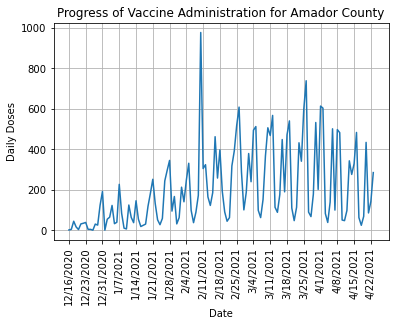

,county,administered_date,total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
716,Amador,12/16/2020,2,2,0,0,2,2,0,0,2
717,Amador,12/17/2020,5,5,0,0,5,7,0,0,5
718,Amador,12/18/2020,45,45,0,0,45,52,0,0,45
719,Amador,12/19/2020,17,17,0,0,17,69,0,0,17
720,Amador,12/20/2020,4,4,0,0,4,73,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
839,Amador,4/19/2021,69,27,42,0,31,7240,37,9296,33
840,Amador,4/20/2021,434,53,381,0,111,7036,317,9613,113
841,Amador,4/21/2021,86,33,53,0,43,7037,42,9655,43
842,Amador,4/22/2021,143,66,76,1,61,7021,78,9733,62


In [39]:
print(f"California counties: {list(county_location.county)}")
county_of_interest = input("Type in the county name to view its Covid-19 vaccination history: ")

vax_hist = vaccine_df[vaccine_df.county==county_of_interest]
plt.plot(vax_hist.administered_date,vax_hist.total_doses)
plt.xticks(vax_hist.administered_date[0::7],rotation=90)
plt.xlabel('Date')
plt.ylabel('Daily Doses')
plt.title(f'Progress of Vaccine Administration for {county_of_interest} County')
plt.grid()
plt.show()

### 4.	Can we predict when California will return to “normal”?